In this notebook, different statistics of the detected ramp planes will be analyzed and visualized.<br>
Also a score will be calculated to determine how well the algorithm works.<br>
This will be done for multiple rosbags to get an average score.

In [1]:
from tf.transformations import euler_from_quaternion, euler_matrix
import ros_numpy
import pcl
import numpy as np
import math
import rosbag
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = 'plotly_dark'
from IPython import display
%load_ext heat

Class of the actual ramp detection algorithm

In [2]:
# My ROS Node
class VisualDetection():

    def __init__(self):
        self.calibrated = False
        self.rp = [0, 0]
        self.ramp_data = [[] for i in range(5)]
        self.publish_clouds = False
        self.arr = np.zeros((1,3))
        # x coordinates where ramp starts
        self.ramp_start = x_range[0]

    def spin(self, cloud, pose):
        self.cloud = cloud
        self.pose = pose
        # Robosense Lidar has a rate of 10 Hz
        # Convert PointCloud2 msg to numpy array
        pc_array = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(self.cloud, remove_nans=True)

        # Apply lidar to car frame transformation
        pc_array_tf = self.transform_pc(pc_array, roll=0, pitch=19.174, yaw=0, transl_x=-1.944)

        # Filter unwanted points (to reduce point cloud size) with passthrough filter
        # TODO: Check if Points further than 30m have intensity less than 10%
        # * Max Range of lidar is 100m (30m @ 10% NIST)
        pc_array_cut = self.reduce_pc(pc_array_tf, 0, 30, -3.5, 3.5, -1, 1.5)
            
        # Convert numpy array to pcl object
        pc_cut = pcl.PointCloud()
        pc_cut.from_array(pc_array_cut.astype('float32'))

        # Downsample point cloud using voxel filter to further decrease size
        pc_small = self.voxel_filter(pc_cut, 0.1)
        if self.publish_clouds: self.publish_pc(pc_small.to_list(), 'pc_small')

        # Perform RANSAC until no new planes are being detected
        plane_coor, data = self.plane_detection(pc_small, 100, 4)
        return plane_coor, data, self.relative_to_absolute(pc_array_cut)
        # self.ramp_detection_confidence(10, 5, data)

    def transform_pc(self, pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
        """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc, rot)

        # Translation
        translation = [transl_x, transl_y, transl_z]
        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def reduce_pc(self, pc, x_lower, x_upper, y_lower, y_upper, z_lower, z_upper):
        """Removes points outside of box"""
        pc_cut = pc[(pc[:, 0] > x_lower) & (pc[:, 0] < x_upper) & (pc[:, 1] > y_lower) & (
            pc[:, 1] < y_upper) & (pc[:, 2] > z_lower) & (pc[:, 2] < z_upper)]
        return pc_cut

    def voxel_filter(self, pc, leaf_size):
        """Downsample point cloud using voxel filter"""
        vg = pc.make_voxel_grid_filter()
        # Leaf_size is the length of the side of the voxel cube in m
        vg.set_leaf_size(leaf_size, leaf_size, leaf_size)
        pc_filtered = vg.filter()
        # print('Reduced size from {} to {}'.format(pc.size, pc_filtered.size))
        return pc_filtered

    def plane_detection(self, pc, min_points, max_planes):
        """Detects all planes in point cloud"""
        # Ground vector
        g_vec = None
        counter = 0
        while pc.size > min_points and counter < max_planes:
            # Detect most dominate plane and get inliers and normal vector
            indices, coefficients = self.ransac(pc)
            n_vec = coefficients[:-1]

            # Split pointcloud in inliers and outliers of plane
            pc, plane, pc_points = self.split_pc(pc, indices)

            # Exit if plane is empty
            if not plane:
                # print('ERROR: No plane could be detected')
                return [], []

            # Ignore walls to the side or in front
            if self.is_plane_near_ground(n_vec):
                # First ground like detection is most probably the ground
                if g_vec is None:
                    g_vec = n_vec
                    if self.publish_clouds: self.publish_pc(plane, 'pc_ground')
                # Either ground is detected again or potential ramp
                else:
                    # self.pub_angle.publish(angle)
                    is_ramp, data = self.ramp_detection(plane, g_vec, n_vec, 4, 7, 2, 4)
                    if is_ramp:
                        # Transform plane from local rslidar coordinates to global map coordinates
                        plane_global = self.relative_to_absolute(plane)
                    
                        if self.publish_clouds: self.publish_pc(plane, 'pc_ramp')
                        return plane_global, data
                    else:  
                        continue
            counter += 1
        return [], []

    def relative_to_absolute(self, pc):
        """Transforms relative lidar data to absolute by adding translation rotating"""
        # pc_arr = pc.to_array()
        pc_arr = np.array(pc)
    
        # Odometer
        pos = self.pose.position
        translation = [pos.x, pos.y, pos.z]
        ori = self.pose.orientation
        quat = [ori.x, ori.y, ori.z, ori.w]
        roll, pitch, yaw = euler_from_quaternion(quat)

        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc_arr, rot)

        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def ramp_detection(
            self, plane, g_vec, n_vec, min_angle, max_angle, 
            min_width, max_width, logging=False):
        """Checks if conditions to be considered a ramp are fullfilled."""
        # Convert pcl plane to numpy array
        plane_array = np.array(plane)

        # Calculate angle [deg] between new and previously recorded normal vector of ground
        angle = self.angle_calc(g_vec, n_vec)
        # Assert ramp angle threshold
        if min_angle <= angle <= max_angle:
            if logging: print('ANGLE PASSED')
            pass
        else:
            if logging: print('Angle wrong with {}'.format(angle))
            return False, []

        # Get ramp width (Difference between y-values)
        width = max(plane_array[:, 1]) - min(plane_array[:, 1])
        # Assert ramp width threshold
        if min_width <= width <= max_width:
            if logging: print('WIDTH PASSED')
            pass
        else:
            if logging: print('Width wrong with {}'.format(width))
            return False, []

        # Ramp distance (x-value of nearest point of the plane)
        dist = min(plane_array[:,0])

        self.angle = angle
        self.d = dist
        if logging:
            print('Possible ramp in {:05.2f}m with angle {:05.2f}deg and width {:05.2f}m'.format(
            dist, angle, width))        
        true_dist = self.ramp_start - self.pose.position.x
        return True, [angle, width, dist, true_dist]

    def ransac(self, pc):
        """Finds inliers and normal vector of dominant plane"""
        # 50?
        seg = pc.make_segmenter_normals(50)
        # Doubles the speed if True
        seg.set_optimize_coefficients(True)
        seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
        seg.set_method_type(pcl.SAC_RANSAC)
        # How close a point must be to model to be considered inlier
        seg.set_distance_threshold(0.01)
        # normal_distance_weight?
        seg.set_normal_distance_weight(0.01)
        # How many tries
        seg.set_max_iterations(100)
        indices, coefficients = seg.segment()
        return indices, coefficients

    def split_pc(self, pc, inliers):
        """Extract detected plane from point cloud and split into two pcs"""
        # Get point cooridnates of plane
        detected_plane = [pc[i] for i in inliers]
        # Point cloud of detected plane (inliers)
        pc_inliers = pc.extract(inliers)

        # Point cloud of outliers
        outlier_indices = list(set(np.arange(pc.size)).symmetric_difference(inliers))
        pc_outliers = pc.extract(outlier_indices)

        return pc_outliers, detected_plane, pc_inliers

    def is_plane_near_ground(self, v, threshold=0.8):
        """Returns True if plane is on the ground (and false if e.g. side wall)"""
        return abs(v[2]) > threshold   

    def angle_calc(self, v1, v2, degrees=True):
        """Calculate angle between two vectors (planes)"""
        # Assuming both vectors can be rotated alongside one axis to be aligned
        dot = np.dot(v1, v2)
        if dot <= 1:
            angle = np.arccos(dot)
        else:
            # print('ERROR: dot product > 1')
            # print('v1 is {} abs({}) and v2 is {} abs ({})'.format(v1, np.linalg.norm(v1), v2, np.linalg.norm(v2)))
            angle = 0

        if degrees is True:
            return np.degrees(angle)
        else:
            return angle

249500250000


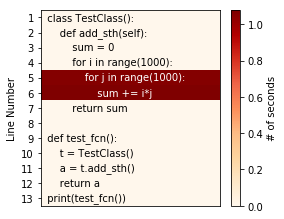

In [16]:
%%heat
class TestClass():
    def add_sth(self):
        sum = 0
        for i in range(1000):
            for j in range(1000):
                sum += i*j
        return sum

def test_fcn():
    t = TestClass()
    a = t.add_sth()
    return a
print(test_fcn())

Load data (pointcloud and odom) from rosbag and make sure both topics are synchronized

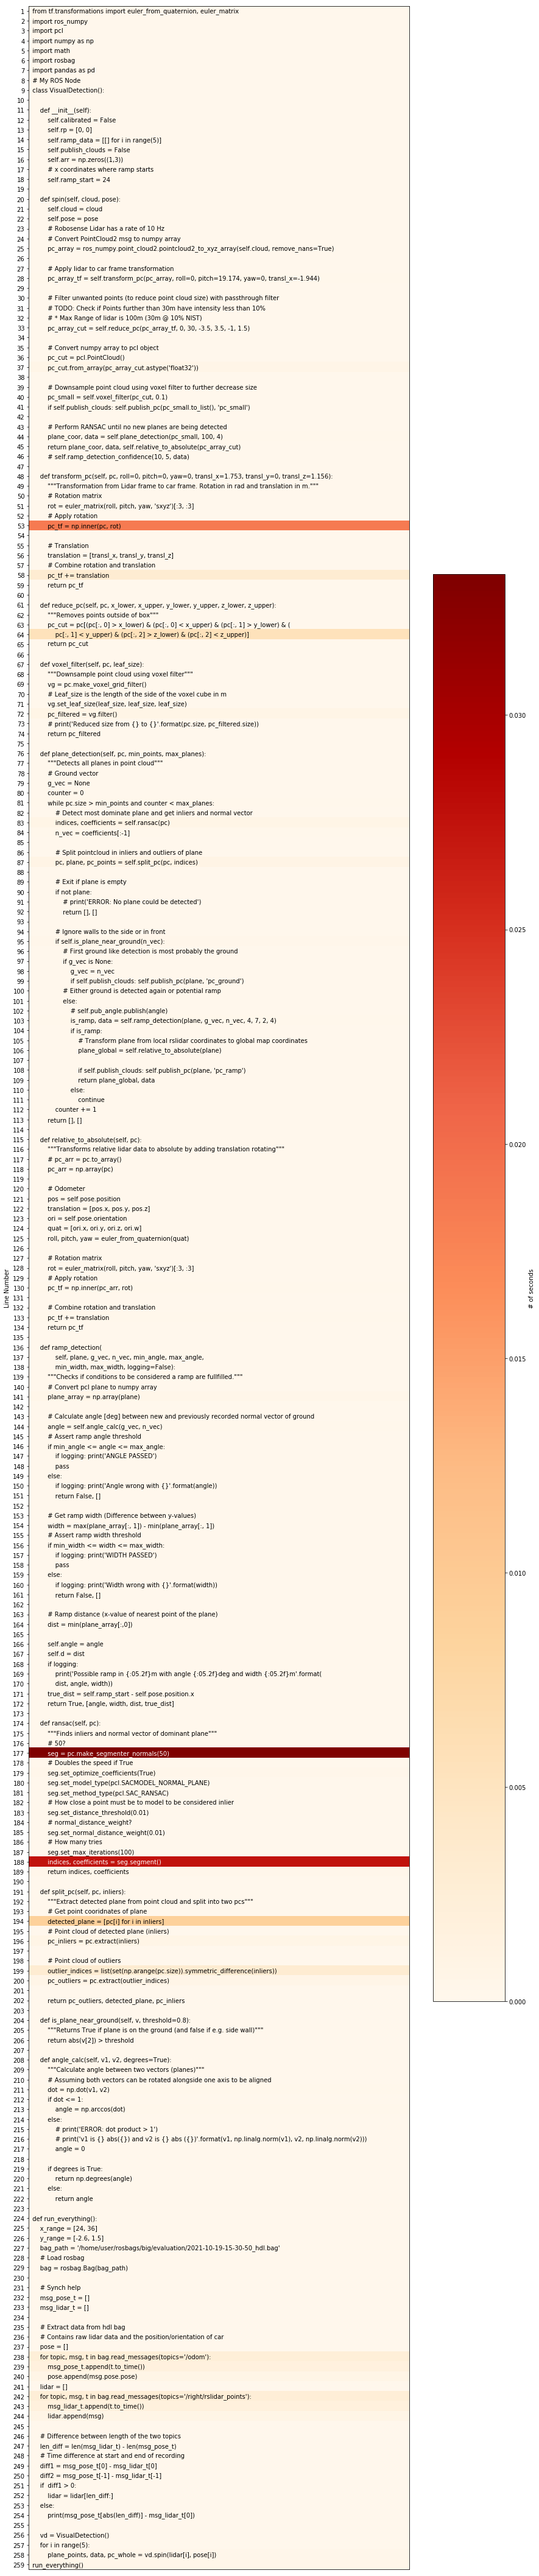

In [24]:
%%heat
from tf.transformations import euler_from_quaternion, euler_matrix
import ros_numpy
import pcl
import numpy as np
import math
import rosbag
import pandas as pd
# My ROS Node
class VisualDetection():

    def __init__(self):
        self.calibrated = False
        self.rp = [0, 0]
        self.ramp_data = [[] for i in range(5)]
        self.publish_clouds = False
        self.arr = np.zeros((1,3))
        # x coordinates where ramp starts
        self.ramp_start = 24

    def spin(self, cloud, pose):
        self.cloud = cloud
        self.pose = pose
        # Robosense Lidar has a rate of 10 Hz
        # Convert PointCloud2 msg to numpy array
        pc_array = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(self.cloud, remove_nans=True)

        # Apply lidar to car frame transformation
        pc_array_tf = self.transform_pc(pc_array, roll=0, pitch=19.174, yaw=0, transl_x=-1.944)

        # Filter unwanted points (to reduce point cloud size) with passthrough filter
        # TODO: Check if Points further than 30m have intensity less than 10%
        # * Max Range of lidar is 100m (30m @ 10% NIST)
        pc_array_cut = self.reduce_pc(pc_array_tf, 0, 30, -3.5, 3.5, -1, 1.5)
            
        # Convert numpy array to pcl object
        pc_cut = pcl.PointCloud()
        pc_cut.from_array(pc_array_cut.astype('float32'))

        # Downsample point cloud using voxel filter to further decrease size
        pc_small = self.voxel_filter(pc_cut, 0.1)
        if self.publish_clouds: self.publish_pc(pc_small.to_list(), 'pc_small')

        # Perform RANSAC until no new planes are being detected
        plane_coor, data = self.plane_detection(pc_small, 100, 4)
        return plane_coor, data, self.relative_to_absolute(pc_array_cut)
        # self.ramp_detection_confidence(10, 5, data)

    def transform_pc(self, pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
        """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc, rot)

        # Translation
        translation = [transl_x, transl_y, transl_z]
        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def reduce_pc(self, pc, x_lower, x_upper, y_lower, y_upper, z_lower, z_upper):
        """Removes points outside of box"""
        pc_cut = pc[(pc[:, 0] > x_lower) & (pc[:, 0] < x_upper) & (pc[:, 1] > y_lower) & (
            pc[:, 1] < y_upper) & (pc[:, 2] > z_lower) & (pc[:, 2] < z_upper)]
        return pc_cut

    def voxel_filter(self, pc, leaf_size):
        """Downsample point cloud using voxel filter"""
        vg = pc.make_voxel_grid_filter()
        # Leaf_size is the length of the side of the voxel cube in m
        vg.set_leaf_size(leaf_size, leaf_size, leaf_size)
        pc_filtered = vg.filter()
        # print('Reduced size from {} to {}'.format(pc.size, pc_filtered.size))
        return pc_filtered

    def plane_detection(self, pc, min_points, max_planes):
        """Detects all planes in point cloud"""
        # Ground vector
        g_vec = None
        counter = 0
        while pc.size > min_points and counter < max_planes:
            # Detect most dominate plane and get inliers and normal vector
            indices, coefficients = self.ransac(pc)
            n_vec = coefficients[:-1]

            # Split pointcloud in inliers and outliers of plane
            pc, plane, pc_points = self.split_pc(pc, indices)

            # Exit if plane is empty
            if not plane:
                # print('ERROR: No plane could be detected')
                return [], []

            # Ignore walls to the side or in front
            if self.is_plane_near_ground(n_vec):
                # First ground like detection is most probably the ground
                if g_vec is None:
                    g_vec = n_vec
                    if self.publish_clouds: self.publish_pc(plane, 'pc_ground')
                # Either ground is detected again or potential ramp
                else:
                    # self.pub_angle.publish(angle)
                    is_ramp, data = self.ramp_detection(plane, g_vec, n_vec, 4, 7, 2, 4)
                    if is_ramp:
                        # Transform plane from local rslidar coordinates to global map coordinates
                        plane_global = self.relative_to_absolute(plane)
                    
                        if self.publish_clouds: self.publish_pc(plane, 'pc_ramp')
                        return plane_global, data
                    else:  
                        continue
            counter += 1
        return [], []

    def relative_to_absolute(self, pc):
        """Transforms relative lidar data to absolute by adding translation rotating"""
        # pc_arr = pc.to_array()
        pc_arr = np.array(pc)
    
        # Odometer
        pos = self.pose.position
        translation = [pos.x, pos.y, pos.z]
        ori = self.pose.orientation
        quat = [ori.x, ori.y, ori.z, ori.w]
        roll, pitch, yaw = euler_from_quaternion(quat)

        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc_arr, rot)

        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def ramp_detection(
            self, plane, g_vec, n_vec, min_angle, max_angle, 
            min_width, max_width, logging=False):
        """Checks if conditions to be considered a ramp are fullfilled."""
        # Convert pcl plane to numpy array
        plane_array = np.array(plane)

        # Calculate angle [deg] between new and previously recorded normal vector of ground
        angle = self.angle_calc(g_vec, n_vec)
        # Assert ramp angle threshold
        if min_angle <= angle <= max_angle:
            if logging: print('ANGLE PASSED')
            pass
        else:
            if logging: print('Angle wrong with {}'.format(angle))
            return False, []

        # Get ramp width (Difference between y-values)
        width = max(plane_array[:, 1]) - min(plane_array[:, 1])
        # Assert ramp width threshold
        if min_width <= width <= max_width:
            if logging: print('WIDTH PASSED')
            pass
        else:
            if logging: print('Width wrong with {}'.format(width))
            return False, []

        # Ramp distance (x-value of nearest point of the plane)
        dist = min(plane_array[:,0])

        self.angle = angle
        self.d = dist
        if logging:
            print('Possible ramp in {:05.2f}m with angle {:05.2f}deg and width {:05.2f}m'.format(
            dist, angle, width))        
        true_dist = self.ramp_start - self.pose.position.x
        return True, [angle, width, dist, true_dist]

    def ransac(self, pc):
        """Finds inliers and normal vector of dominant plane"""
        # 50?
        seg = pc.make_segmenter_normals(50)
        # Doubles the speed if True
        seg.set_optimize_coefficients(True)
        seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
        seg.set_method_type(pcl.SAC_RANSAC)
        # How close a point must be to model to be considered inlier
        seg.set_distance_threshold(0.01)
        # normal_distance_weight?
        seg.set_normal_distance_weight(0.01)
        # How many tries
        seg.set_max_iterations(100)
        indices, coefficients = seg.segment()
        return indices, coefficients

    def split_pc(self, pc, inliers):
        """Extract detected plane from point cloud and split into two pcs"""
        # Get point cooridnates of plane
        detected_plane = [pc[i] for i in inliers]
        # Point cloud of detected plane (inliers)
        pc_inliers = pc.extract(inliers)

        # Point cloud of outliers
        outlier_indices = list(set(np.arange(pc.size)).symmetric_difference(inliers))
        pc_outliers = pc.extract(outlier_indices)

        return pc_outliers, detected_plane, pc_inliers

    def is_plane_near_ground(self, v, threshold=0.8):
        """Returns True if plane is on the ground (and false if e.g. side wall)"""
        return abs(v[2]) > threshold   

    def angle_calc(self, v1, v2, degrees=True):
        """Calculate angle between two vectors (planes)"""
        # Assuming both vectors can be rotated alongside one axis to be aligned
        dot = np.dot(v1, v2)
        if dot <= 1:
            angle = np.arccos(dot)
        else:
            # print('ERROR: dot product > 1')
            # print('v1 is {} abs({}) and v2 is {} abs ({})'.format(v1, np.linalg.norm(v1), v2, np.linalg.norm(v2)))
            angle = 0

        if degrees is True:
            return np.degrees(angle)
        else:
            return angle

def run_everything():
    x_range = [24, 36]
    y_range = [-2.6, 1.5] 
    bag_path = '/home/user/rosbags/big/evaluation/2021-10-19-15-30-50_hdl.bag'
    # Load rosbag
    bag = rosbag.Bag(bag_path)

    # Synch help
    msg_pose_t = []
    msg_lidar_t = []

    # Extract data from hdl bag
    # Contains raw lidar data and the position/orientation of car
    pose = []
    for topic, msg, t in bag.read_messages(topics='/odom'):
        msg_pose_t.append(t.to_time())
        pose.append(msg.pose.pose)
    lidar = []
    for topic, msg, t in bag.read_messages(topics='/right/rslidar_points'):
        msg_lidar_t.append(t.to_time())
        lidar.append(msg)

    # Difference between length of the two topics
    len_diff = len(msg_lidar_t) - len(msg_pose_t)
    # Time difference at start and end of recording
    diff1 = msg_pose_t[0] - msg_lidar_t[0]
    diff2 = msg_pose_t[-1] - msg_lidar_t[-1]
    if  diff1 > 0:
        lidar = lidar[len_diff:]
    else:
        print(msg_pose_t[abs(len_diff)] - msg_lidar_t[0])

    vd = VisualDetection()
    for i in range(5):
        plane_points, data, pc_whole = vd.spin(lidar[i], pose[i])
run_everything()

In [25]:
%%timeit

from tf.transformations import euler_from_quaternion, euler_matrix
import ros_numpy
import pcl
import numpy as np
import math
import rosbag
import pandas as pd
# My ROS Node
class VisualDetection():

    def __init__(self):
        self.calibrated = False
        self.rp = [0, 0]
        self.ramp_data = [[] for i in range(5)]
        self.publish_clouds = False
        self.arr = np.zeros((1,3))
        # x coordinates where ramp starts
        self.ramp_start = 24

    def spin(self, cloud, pose):
        self.cloud = cloud
        self.pose = pose
        # Robosense Lidar has a rate of 10 Hz
        # Convert PointCloud2 msg to numpy array
        pc_array = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(self.cloud, remove_nans=True)

        # Apply lidar to car frame transformation
        pc_array_tf = self.transform_pc(pc_array, roll=0, pitch=19.174, yaw=0, transl_x=-1.944)

        # Filter unwanted points (to reduce point cloud size) with passthrough filter
        # TODO: Check if Points further than 30m have intensity less than 10%
        # * Max Range of lidar is 100m (30m @ 10% NIST)
        pc_array_cut = self.reduce_pc(pc_array_tf, 0, 30, -3.5, 3.5, -1, 1.5)
            
        # Convert numpy array to pcl object
        pc_cut = pcl.PointCloud()
        pc_cut.from_array(pc_array_cut.astype('float32'))

        # Downsample point cloud using voxel filter to further decrease size
        pc_small = self.voxel_filter(pc_cut, 0.1)
        if self.publish_clouds: self.publish_pc(pc_small.to_list(), 'pc_small')

        # Perform RANSAC until no new planes are being detected
        plane_coor, data = self.plane_detection(pc_small, 100, 4)
        return plane_coor, data, self.relative_to_absolute(pc_array_cut)
        # self.ramp_detection_confidence(10, 5, data)

    def transform_pc(self, pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
        """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc, rot)

        # Translation
        translation = [transl_x, transl_y, transl_z]
        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def reduce_pc(self, pc, x_lower, x_upper, y_lower, y_upper, z_lower, z_upper):
        """Removes points outside of box"""
        pc_cut = pc[(pc[:, 0] > x_lower) & (pc[:, 0] < x_upper) & (pc[:, 1] > y_lower) & (
            pc[:, 1] < y_upper) & (pc[:, 2] > z_lower) & (pc[:, 2] < z_upper)]
        return pc_cut

    def voxel_filter(self, pc, leaf_size):
        """Downsample point cloud using voxel filter"""
        vg = pc.make_voxel_grid_filter()
        # Leaf_size is the length of the side of the voxel cube in m
        vg.set_leaf_size(leaf_size, leaf_size, leaf_size)
        pc_filtered = vg.filter()
        # print('Reduced size from {} to {}'.format(pc.size, pc_filtered.size))
        return pc_filtered

    def plane_detection(self, pc, min_points, max_planes):
        """Detects all planes in point cloud"""
        # Ground vector
        g_vec = None
        counter = 0
        while pc.size > min_points and counter < max_planes:
            # Detect most dominate plane and get inliers and normal vector
            indices, coefficients = self.ransac(pc)
            n_vec = coefficients[:-1]

            # Split pointcloud in inliers and outliers of plane
            pc, plane, pc_points = self.split_pc(pc, indices)

            # Exit if plane is empty
            if not plane:
                # print('ERROR: No plane could be detected')
                return [], []

            # Ignore walls to the side or in front
            if self.is_plane_near_ground(n_vec):
                # First ground like detection is most probably the ground
                if g_vec is None:
                    g_vec = n_vec
                    if self.publish_clouds: self.publish_pc(plane, 'pc_ground')
                # Either ground is detected again or potential ramp
                else:
                    # self.pub_angle.publish(angle)
                    is_ramp, data = self.ramp_detection(plane, g_vec, n_vec, 4, 7, 2, 4)
                    if is_ramp:
                        # Transform plane from local rslidar coordinates to global map coordinates
                        plane_global = self.relative_to_absolute(plane)
                    
                        if self.publish_clouds: self.publish_pc(plane, 'pc_ramp')
                        return plane_global, data
                    else:  
                        continue
            counter += 1
        return [], []

    def relative_to_absolute(self, pc):
        """Transforms relative lidar data to absolute by adding translation rotating"""
        # pc_arr = pc.to_array()
        pc_arr = np.array(pc)
    
        # Odometer
        pos = self.pose.position
        translation = [pos.x, pos.y, pos.z]
        ori = self.pose.orientation
        quat = [ori.x, ori.y, ori.z, ori.w]
        roll, pitch, yaw = euler_from_quaternion(quat)

        # Rotation matrix
        rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
        # Apply rotation
        pc_tf = np.inner(pc_arr, rot)

        # Combine rotation and translation
        pc_tf += translation
        return pc_tf

    def ramp_detection(
            self, plane, g_vec, n_vec, min_angle, max_angle, 
            min_width, max_width, logging=False):
        """Checks if conditions to be considered a ramp are fullfilled."""
        # Convert pcl plane to numpy array
        plane_array = np.array(plane)

        # Calculate angle [deg] between new and previously recorded normal vector of ground
        angle = self.angle_calc(g_vec, n_vec)
        # Assert ramp angle threshold
        if min_angle <= angle <= max_angle:
            if logging: print('ANGLE PASSED')
            pass
        else:
            if logging: print('Angle wrong with {}'.format(angle))
            return False, []

        # Get ramp width (Difference between y-values)
        width = max(plane_array[:, 1]) - min(plane_array[:, 1])
        # Assert ramp width threshold
        if min_width <= width <= max_width:
            if logging: print('WIDTH PASSED')
            pass
        else:
            if logging: print('Width wrong with {}'.format(width))
            return False, []

        # Ramp distance (x-value of nearest point of the plane)
        dist = min(plane_array[:,0])

        self.angle = angle
        self.d = dist
        if logging:
            print('Possible ramp in {:05.2f}m with angle {:05.2f}deg and width {:05.2f}m'.format(
            dist, angle, width))        
        true_dist = self.ramp_start - self.pose.position.x
        return True, [angle, width, dist, true_dist]

    def ransac(self, pc):
        """Finds inliers and normal vector of dominant plane"""
        # 50?
        seg = pc.make_segmenter_normals(50)
        # Doubles the speed if True
        seg.set_optimize_coefficients(True)
        seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
        seg.set_method_type(pcl.SAC_RANSAC)
        # How close a point must be to model to be considered inlier
        seg.set_distance_threshold(0.01)
        # normal_distance_weight?
        seg.set_normal_distance_weight(0.01)
        # How many tries
        seg.set_max_iterations(100)
        indices, coefficients = seg.segment()
        return indices, coefficients

    def split_pc(self, pc, inliers):
        """Extract detected plane from point cloud and split into two pcs"""
        # Get point cooridnates of plane
        detected_plane = [pc[i] for i in inliers]
        # Point cloud of detected plane (inliers)
        pc_inliers = pc.extract(inliers)

        # Point cloud of outliers
        outlier_indices = list(set(np.arange(pc.size)).symmetric_difference(inliers))
        pc_outliers = pc.extract(outlier_indices)

        return pc_outliers, detected_plane, pc_inliers

    def is_plane_near_ground(self, v, threshold=0.8):
        """Returns True if plane is on the ground (and false if e.g. side wall)"""
        return abs(v[2]) > threshold   

    def angle_calc(self, v1, v2, degrees=True):
        """Calculate angle between two vectors (planes)"""
        # Assuming both vectors can be rotated alongside one axis to be aligned
        dot = np.dot(v1, v2)
        if dot <= 1:
            angle = np.arccos(dot)
        else:
            # print('ERROR: dot product > 1')
            # print('v1 is {} abs({}) and v2 is {} abs ({})'.format(v1, np.linalg.norm(v1), v2, np.linalg.norm(v2)))
            angle = 0

        if degrees is True:
            return np.degrees(angle)
        else:
            return angle

def run_everything():
    x_range = [24, 36]
    y_range = [-2.6, 1.5] 
    bag_path = '/home/user/rosbags/big/evaluation/2021-10-19-15-30-50_hdl.bag'
    # Load rosbag
    bag = rosbag.Bag(bag_path)

    # Synch help
    msg_pose_t = []
    msg_lidar_t = []

    # Extract data from hdl bag
    # Contains raw lidar data and the position/orientation of car
    pose = []
    for topic, msg, t in bag.read_messages(topics='/odom'):
        msg_pose_t.append(t.to_time())
        pose.append(msg.pose.pose)
    lidar = []
    for topic, msg, t in bag.read_messages(topics='/right/rslidar_points'):
        msg_lidar_t.append(t.to_time())
        lidar.append(msg)

    # Difference between length of the two topics
    len_diff = len(msg_lidar_t) - len(msg_pose_t)
    # Time difference at start and end of recording
    diff1 = msg_pose_t[0] - msg_lidar_t[0]
    diff2 = msg_pose_t[-1] - msg_lidar_t[-1]
    if  diff1 > 0:
        lidar = lidar[len_diff:]
    else:
        print(msg_pose_t[abs(len_diff)] - msg_lidar_t[0])

    vd = VisualDetection()
    for i in range(5):
        plane_points, data, pc_whole = vd.spin(lidar[i], pose[i])
run_everything()

1 loop, best of 3: 514 ms per loop


In [39]:
pc = np.random.rand(10000,3)

In [44]:
%%timeit
import numpy as np
from tf.transformations import euler_matrix
def transform_pc(pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
    """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
    # Rotation matrix
    rot = euler_matrix(roll, pitch, yaw, 'sxyz')[:3, :3]
    # Apply rotation
    pc_tf = np.inner(pc, rot)

    # Translation
    translation = [transl_x, transl_y, transl_z]
    # Combine rotation and translation
    pc_tf += translation
    return pc_tf


transform_pc(pc, pitch=0.3)

10000 loops, best of 3: 102 µs per loop


In [ ]:
import numpy as np
from tf.transformations import euler_matrix, quaternion_from_euler

In [52]:
%%timeit

def transform_pc(pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
    """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
    # Rotation matrix
    rot = euler_matrix(roll, pitch, yaw)[:3,:3]
    # Apply rotation
    pc_tf = np.dot(pc, rot)

    # Translation
    translation = [transl_x, transl_y, transl_z]
    # Combine rotation and translation
    pc_tf += translation
    return pc_tf


transform_pc(pc, pitch=0.3)

10000 loops, best of 3: 108 µs per loop


In [51]:
from scipy.spatial.transform import Rotation
import numpy as np
from tf.transformations import euler_matrix, quaternion_from_euler

In [ ]:
%%timeit

def transform_pc(pc, roll=0, pitch=0, yaw=0, transl_x=1.753, transl_y=0, transl_z=1.156):
    """Transformation from Lidar frame to car frame. Rotation in rad and translation in m."""
    # Rotation matrix
    rot = Rotation.from_euler(roll, pitch, yaw)
    rot.apply(pc)
    # Apply rotation
    pc_tf = np.dot(pc, rot)

    # Translation
    translation = [transl_x, transl_y, transl_z]
    # Combine rotation and translation
    pc_tf += translation
    return pc_tf


transform_pc(pc, pitch=0.3)